<a href="https://colab.research.google.com/github/DKwokAsc/MCMC-Final-Project/blob/main/Wisconsin_MCMC_GerryChainv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Wisconsin MCMC GerryChain Partition and Elections**

This file creates partitions and ensembles for Markov Chain, Partitions and Elections


---


Requirements:
- `wi_2024_gen_prec_graph.json` must already be downloaded and inputted in the default file folder. If not, see the instructions on `Wisconsin_SHP_File_Conversion.ipynb`





In [40]:
# Install gerrychain packages
!pip install gerrychain[geo]

In [41]:
# Install additional dependencies
# Credit to the GerryChain documentation & tutorial for providing many of the
# examples done in this demo
from gerrychain import Graph, Partition, MarkovChain, Election, metrics
from gerrychain.proposals import propose_random_flip,recom
from gerrychain.updaters import Tally, cut_edges
from gerrychain.constraints import Validator, single_flip_contiguous, contiguous, within_percent_of_ideal_population # used for validators
from gerrychain.accept import always_accept
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle

import random
random.seed(42)

#**Winconsin Election Addition**

In [42]:
# Remove empty row warnings (to decide later)
import warnings
warnings.filterwarnings("ignore")

# Initialize the graph for chains
graph = Graph.from_json("./wi_2024_gen_prec_graph.json")

# Create the election first to validate data
election = Election(
    "PRES24",
    {"Dem":"PREDEM24", "Rep":"PREREP24"}
)

# Create 3 plans: One for congressionalm one for state assembly, one for state district

cong_partition = Partition(
    graph,
    assignment="CONG_DIST",
    updaters={
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election
    }
)

state_assem_partition = Partition(
    graph,
    assignment="SLDL_DIST",
    updaters={
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election
    }
)

state_dist_partition = Partition(
    graph,
    assignment="SLDU_DIST",
    updaters={
        "population": Tally("PERSONS", alias="population"),
        "cut_edges": cut_edges,
        "PRES24": election
    }
)

# Prints output returns population info based on the plan chosen
def print_population(name, partition):
  print(f"\n{name} Plan Population:")
  for district, pop in partition["population"].items():
      print(f"  District {district}: {pop}")


# Sanity check
print_population("Congressional", cong_partition)
print_population("State Assembly", state_assem_partition)
print_population("State district", state_dist_partition)


Congressional Plan Population:
  District 03: 736716.0
  District 07: 736715.0
  District 08: 736714.0
  District 06: 736692.0
  District 02: 736715.0
  District 05: 736737.0
  District 01: 736715.0
  District 04: 736714.0

State Assembly Plan Population:
  District 72: 59742.0
  District 57: 59642.0
  District 41: 59672.0
  District 39: 59796.0
  District 71: 59463.0
  District 74: 58968.0
  District 73: 59853.0
  District 67: 60062.0
  District 88: 59855.0
  District 89: 59697.0
  District 02: 59983.0
  District 01: 59444.0
  District 90: 59551.0
  District 04: 60096.0
  District 05: 59076.0
  District 06: 59188.0
  District 29: 59983.0
  District 75: 60058.0
  District 03: 59173.0
  District 27: 60058.0
  District 68: 59902.0
  District 69: 59952.0
  District 91: 60072.0
  District 92: 58940.0
  District 42: 59201.0
  District 40: 59478.0
  District 37: 59609.0
  District 49: 59584.0
  District 47: 58987.0
  District 46: 59231.0
  District 50: 59024.0
  District 81: 60040.0
  Distr

**Efficiency Gap measuring for democratic and republican party**

In [43]:

# Function that calculate results based on the selected partition
# Returns: two outputs; the efficiency gap of the selected parition and the number of seats won by republicans
def summarize_election(partition):
  # Create the election based on the selected map "partition"
  election_map = partition["PRES24"]
  # Compute the efficiency gap using metrics.efficiency_gap
  efficiency_gap = metrics.efficiency_gap(election_map)

  # Compute the number of districts won by republicans
  rep_wins = election_map.seats("Rep")

  return efficiency_gap, rep_wins

# Function: Printing function for election results
# Returns: Print desired output based on the selected map, its efficiency gap and seats taken
def print_results(name, efficiency_gap, districts_won):
  print(f"{name} Voting Results")
  print(f"Efficiency gap: {efficiency_gap:0.4f}")
  print(f"Districts won: {districts_won}")

eg_dem, rep_wins_dem = summarize_election(cong_partition)
print_results("Congressional Plan", eg_dem, rep_wins_dem)

eg_rep, rep_wins_rep = summarize_election(state_assem_partition)
print_results("State Assembly Plan", eg_rep, rep_wins_rep)

eg_comp, rep_wins_comp = summarize_election(state_dist_partition)
print_results("State District Plan", eg_rep, rep_wins_comp)

Congressional Plan Voting Results
Efficiency gap: -0.2535
Districts won: 6
State Assembly Plan Voting Results
Efficiency gap: -0.0261
Districts won: 50
State District Plan Voting Results
Efficiency gap: -0.0261
Districts won: 15


#**Create Mini Ensembles for all 3 Partitions**

In [44]:
# Ensembles
cong_ensemble = []

# Function to generate ensemble
# Returns a list of partitions of ensembles for the specified partition
def ensemble_generation(partition):
  tot_pop = sum(partition["population"].values())
  print(tot_pop)

  tot_districts = len(partition.parts)

  target_pop = tot_pop/tot_districts
  print(target_pop)

  # Add the ReCom proposal method
  proposal = partial(
      recom,
      pop_col="TOT_POP",
      pop_target=target_pop,
      epsilon=0.01,
      node_repeats=2
  )

  # Create the Markov chain
  chain = MarkovChain(
      proposal= propose_random_flip,
      constraints=[within_percent_of_ideal_population(partition, 0.01)],
      accept=always_accept,
      initial_state=partition,
      total_steps=100
  )
  ensemble =[]
  for step, partition in enumerate(chain):
      ensemble.append(partition)

  print(f"Generated {len(ensemble)} plans.")
  return ensemble

def print_steps(ensemble):
 # Sanity check
  for (i,part) in enumerate(ensemble):
    print(f"Step {i} Rep vote share for dist 1: "
      f"{part['PRES24'].percents('Rep')[1]:0.4f}")


cong_ensemble = ensemble_generation(cong_partition)
state_assem_ensemble = ensemble_generation(state_assem_partition)
state_dist_ensemble = ensemble_generation(state_dist_partition)

# Double check steps
#print_steps(cong_ensemble)


5893718.0
736714.75
Generated 100 plans.
5893718.0
59532.50505050505
Generated 100 plans.
5893718.0
178597.51515151514
Generated 100 plans.


In [45]:
def compute_total_rep_wins(ensemble):
  """Computes total republican wins for a specified ensemble
  Inputs: a designated ensemble as a partition in lists
  Output: two lists given; an efficiency gap list and the total republican wins for that ensemble
  """
  # Output results

  # Store efficiency gap and total republican wins
  # Using the tip create a list that already has the same amount as the chain instead of gradually increasing it
  n = len(ensemble)
  steps_between = 4
  rep_wins_list = [None]*n
  efficiency_gap_list =[None]*n

  # Iterate through all values on the markov chain

  for (i,part) in enumerate(ensemble):
    if i%steps_between == 0:
      # Sum all wins for republicans
      rep_wins_list[i//steps_between]=part["PRES24"].seats("Rep")

      # Sum all efficiency gaps for republicans
      efficiency_gap_list[i//steps_between] = metrics.efficiency_gap(part["PRES24"])


  # Remove all empty spaces in the list
  samples = (n+steps_between-1)//steps_between

  # Slice the array (https://www.geeksforgeeks.org/python/python-arrays/)
  rep_wins_list = rep_wins_list[:samples]
  efficiency_gap_list = efficiency_gap_list[:samples]

  return rep_wins_list, efficiency_gap_list

# Set the correct outputs and lists for the specified functions for sanity check on next cell
cong_rep_wins, cong_eff_gap = compute_total_rep_wins(cong_ensemble)
state_assem_rep_wins, state_assem_eff_gap = compute_total_rep_wins(state_assem_ensemble)
state_dist_rep_wins, state_dist_eff_gap = compute_total_rep_wins(state_dist_ensemble)

In [46]:
# Sanity check for list of republican wins
print("Republican Wins Ensemble Lists")
print(f"  Congressional Republican Wins:{cong_rep_wins}")
print(f"  State Assembly Republican Wins:{state_assem_rep_wins}")
print(f"  State Districting Republican Wins:{state_dist_rep_wins}\n")

# Sanity check for list of efficency gap for republicans
print("Efficiency Gap Lists for Ensembles")
print(f"  Congressional Efficiency Gap:{cong_eff_gap}")
print(f"  State Assembly Efficiency Gap:{state_assem_eff_gap}")
print(f"  State Districting Efficiency Gap:{state_dist_eff_gap}")

Republican Wins Ensemble Lists
  Congressional Republican Wins:[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
  State Assembly Republican Wins:[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
  State Districting Republican Wins:[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]

Efficiency Gap Lists for Ensembles
  Congressional Efficiency Gap:[-0.253532460548657, -0.253773112626658, -0.2535999025507635, -0.2528758666074445, -0.2528758666074445, -0.2528758666074445, -0.2531061201388652, -0.2531607867837444, -0.2530758158031169, -0.25266284495321395, -0.2530431346567217, -0.25267443190511774, -0.25260193918038654, -0.25280367098404416, -0.25297658395860784, -0.2532166418339471, -0.25319019981550006, -0.2530591781285884, -0.25309958390958615, -0.2529771781612696, -0.252834866623785, -0.252834866623785, -0.25305620711527976, -0.2526257072868558, -0.25306333754

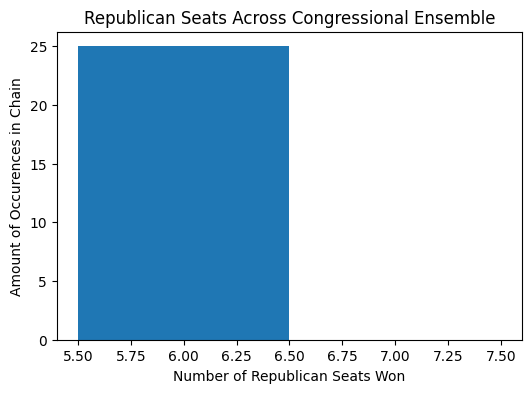

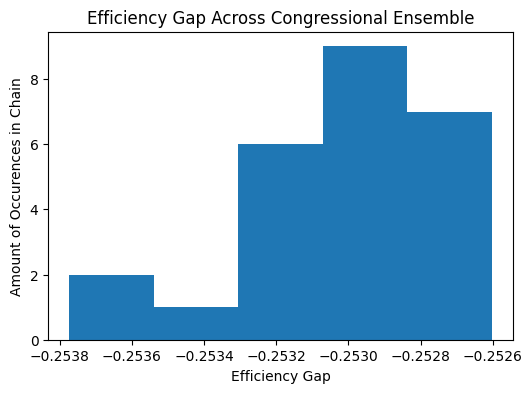

In [48]:
# Create the list for the figures to display
# Figure for republican seats won
# Set the range of bins to be dynamic since number of seats is small in this case
plt.figure(figsize=(6,4))
plt.hist(cong_rep_wins,
         bins=range(min(cong_rep_wins), max(cong_rep_wins)+3),
         align="left")
plt.title("Republican Seats Across Congressional Ensemble")
plt.xlabel("Number of Republican Seats Won")
plt.ylabel("Amount of Occurences in Chain")

plt.show()

# Figure for efficiency gap
# Use a fixed amount of bins in this case since efficiency gap varies alot
plt.figure(figsize=(6,4))
plt.hist(cong_eff_gap, bins=5)
plt.title("Efficiency Gap Across Congressional Ensemble")
plt.xlabel("Efficiency Gap")
plt.ylabel("Amount of Occurences in Chain")

plt.show()
